In [59]:
import pandas as pd
import numpy as np
from itertools import combinations
from collections import defaultdict
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from scipy.sparse import lil_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unidecode
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
from umap.umap_ import UMAP
import matplotlib.pyplot as plt
import random
import nltk
from nltk.corpus import stopwords

# 📝 The purpose of this notebook is to :
- Clean up and standardize recipe ingredients
- Group together semantically similar ingredients (via embeddings)
- Reduce ingredient vocabulary to facilitate analysis
- Visualize clusters and save a cleaned CSV
- Provide an "ingredient -> clean form" dictionary

### 0️⃣ STEP 0 - Setup

In [60]:
df = pd.read_csv("data/clean_data/recipes_truncated.csv")
print(df.shape)
df.head()

(222705, 5)


,name_x,nutrition,n_steps,ingredients_y,minutes
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",55
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",30
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",130
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",45
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",190


#### Parsing the ingredients_y column

In [61]:
# Check the type of the first value
print(f"\nOriginal type of ingredients_y: {type(df['ingredients_y'].iloc[0])}")
print(f"Example: {df['ingredients_y'].iloc[0]}")

# If it's a string (e.g., "['salt', 'pepper']"), convert to a Python list
if isinstance(df['ingredients_y'].iloc[0], str):
    print("Parsing ingredients_y from string to list...")
    df['ingredients_y'] = df['ingredients_y'].apply(ast.literal_eval)
    
# Verification after parsing
print(f"Type after parsing: {type(df['ingredients_y'].iloc[0])}")
print(f"Example after parsing: {df['ingredients_y'].iloc[0]}")


Original type of ingredients_y: <class 'str'>
Example: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Parsing ingredients_y from string to list...
Type after parsing: <class 'list'>
Example after parsing: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


### 🧹 STEP 1 - Lexical cleaning of ingredients

In [62]:
import spacy
import swifter

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

SYNONYMS = {
    "zucchini": "courgette",
    "eggplant": "aubergine",
    "cilantro": "coriander",
    # others
}

NON_FOOD = {
    "plastic", "wrap", "foil", "spray", "paper", "water", "ice", "oil", "salt", "pepper", "pooper scooper"
    # others
}

In [63]:
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet', quiet=True)

lemmatizer = WordNetLemmatizer()

def basic_clean(ing):
    ing = ing.lower()
    ing = unidecode.unidecode(ing)
    ing = re.sub(r"\([^)]*\)", "", ing)
    ing = re.sub(r"[^a-z\s]", "", ing)
    ing = re.sub(r"\s+", " ", ing).strip()
    return ing

def fast_lemmatize(ing):
    return " ".join([lemmatizer.lemmatize(w) for w in ing.split()])

def standardize_ingredient(ing):
    return SYNONYMS.get(ing, ing)

def is_food(ing):
    return ing not in NON_FOOD

def clean_ingredient(ing):
    if not isinstance(ing, str):
        return ""
    ing = basic_clean(ing)
    if not ing:
        return ""
    ing = fast_lemmatize(ing)
    ing = standardize_ingredient(ing)
    return ing if is_food(ing) else ""

print(f"Example before cleaning: {df['ingredients_y'].iloc[0]}")

if isinstance(df["ingredients_y"].iloc[0], str):
    df["ingredients_y"] = df["ingredients_y"].apply(ast.literal_eval)

print("Cleaning ingredients...")

df["ingredients_y"] = df["ingredients_y"].swifter.apply(
    lambda lst: [x for x in (clean_ingredient(i) for i in lst) if x and x is not None]
)

print(f"Example after cleaning: {df['ingredients_y'].iloc[0]}")

Example before cleaning: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Cleaning ingredients...


Pandas Apply: 100%|██████████| 222705/222705 [00:43<00:00, 5167.47it/s]

Example after cleaning: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil']


#### Building the vocabulary of ingredients

In [64]:
# Retrieve all ingredients and deduplicate within each recipe
all_ingredients = []

for ing_list in df['ingredients_y']:
    all_ingredients.extend(set(ing_list))  # removes duplicates within each recipe
    
# Create a list of unique ingredients and an index for each
unique_ingredients = sorted(set(all_ingredients))
ingredients_index = {ing: idx for idx, ing in enumerate(unique_ingredients)}
n = len(unique_ingredients)

print(f"Total number of recipes: {len(df)}")
print(f"Number of unique ingredients: {n}")

Total number of recipes: 222705
Number of unique ingredients: 13355


### 🧠 STEP 2 - Embeddings of unique ingredients

In [65]:
ingredients = list(set(x for lst in df["ingredients_y"] for x in lst))
print("Before reduction:", len(ingredients))

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(ingredients, show_progress_bar=True)

Before reduction: 13355


Batches: 100%|██████████| 418/418 [00:20<00:00, 20.59it/s]


### 🔗 STEP 3 - Semantic clustering of ingredients

In [66]:
sim_matrix = cosine_similarity(embeddings)

# Hierarchical clustering based on cosine similarity
cluster = AgglomerativeClustering(
    n_clusters=None,
    metric="precomputed",
    linkage="average",
    distance_threshold=0.20  # similarity threshold
)

labels = cluster.fit_predict(1 - sim_matrix)

### 🧭 STEP 4 - Creating the ingredient -> representative mapping

In [67]:
mapping_df = pd.DataFrame({"ingredient": ingredients, "cluster": labels})

# Choose the shortest representative for each cluster
representants = (
    mapping_df.groupby("cluster")["ingredient"]
    .apply(lambda g: min(g, key=len))
    .to_dict()
)

# Complete mapping dictionary
mapping = {row["ingredient"]: representants[row["cluster"]] for _, row in mapping_df.iterrows()}
print("After grouping:", len(set(mapping.values())))

# Apply mapping to the DataFrame
df["ingredients_reduced"] = df["ingredients_y"].apply(
    lambda lst: list(set(mapping.get(x, x) for x in lst))
)

After grouping: 7833


### 📊 STEP 5 - Reduction statistics

In [68]:
before = len(ingredients)
after = len(set(mapping.values()))

print(f"Reduction: {before} -> {after} ({((1 - after/before)*100):.1f}%)")

# Display some clusters for inspection
for i in range(5):
    group = mapping_df[mapping_df["cluster"] == i]["ingredient"].tolist()
    print(f"Cluster {i}: {group[:10]}")

Reduction: 13355 -> 7833 (41.3%)
Cluster 0: ['paper cup', 'paper baking cup']
Cluster 1: ['garlic and red chile paste', 'garlic paste']
Cluster 2: ['homemade beef stock', 'beef stock', 'beef stock mix', 'white beef stock']
Cluster 3: ['distilled white vinegar', 'hot spiced white vinegar', 'distilled vinegar', 'white distilled vinegar']
Cluster 4: ['chicken stuffing mix', 'stove top lowsodium chicken stuffing mix', 'stove top stuffing mix', 'reducedsodium chicken flavor stuffing mix', 'chicken flavor stuffing mix', 'chicken stove top stuffing mix']


### 🎨 STEP 6 - UMAP cluster visualization

c:\Users\edgar\anaconda3\envs\food_mining\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


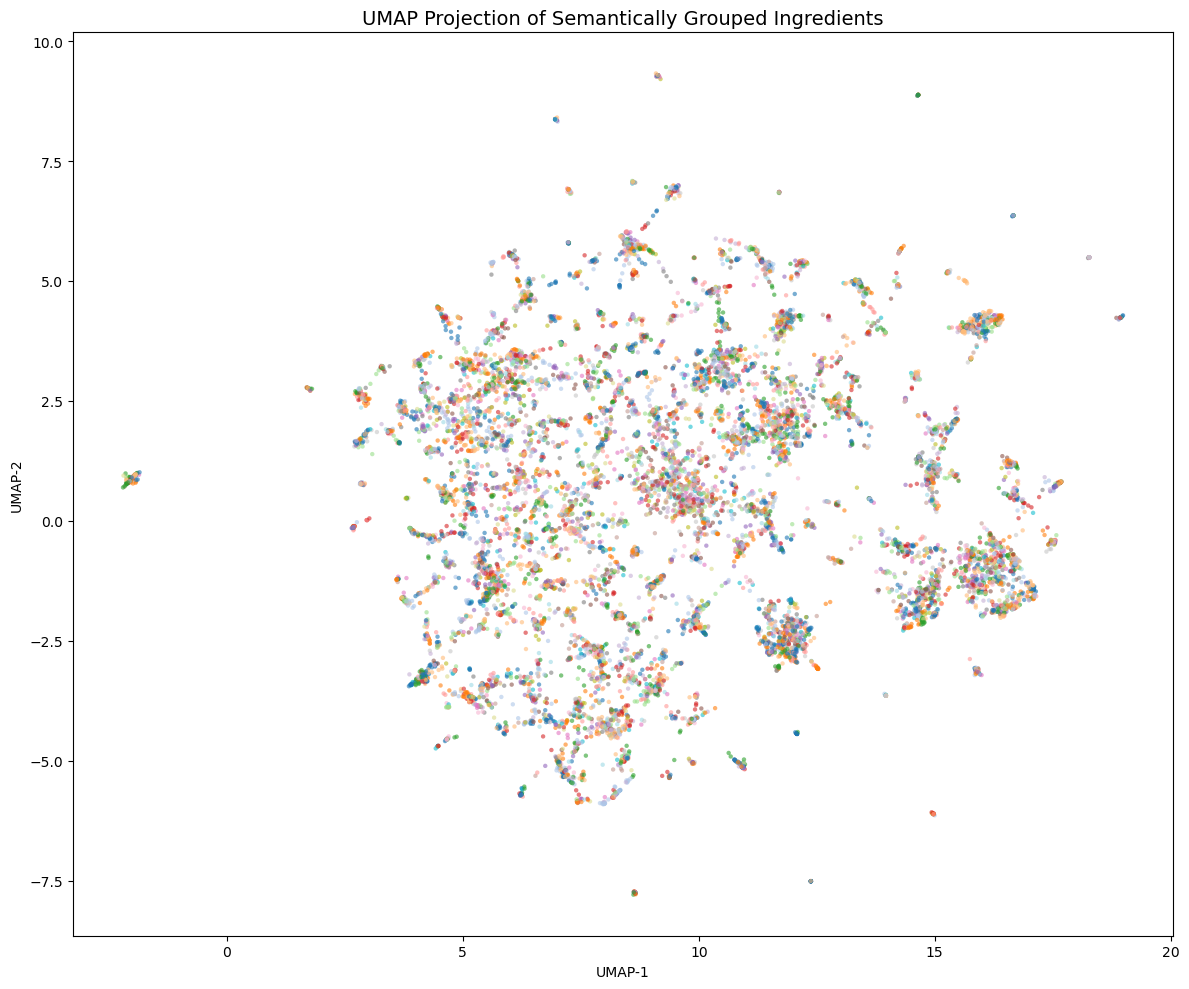

(13355, 2) [[ 9.939552   -0.02072741]
 [16.142824    4.031004  ]
 [13.221285    2.8794508 ]
 [ 6.525871   -0.97771484]
 [15.003638    1.1572015 ]]
7833 0    6243
1    6706
2    7585
3    6975
4    7508
Name: cluster, dtype: int64
ingredient    0
cluster       0
x             0
y             0
dtype: int64


In [69]:
umap = UMAP(n_neighbors=15, min_dist=0.1, metric='cosine', random_state=42)

emb_2d = umap.fit_transform(embeddings)
mapping_df["x"] = emb_2d[:, 0]
mapping_df["y"] = emb_2d[:, 1]

plt.figure(figsize=(12,10))
plt.scatter(
    mapping_df["x"],
    mapping_df["y"],
    c=mapping_df["cluster"].astype(float),
    cmap="tab20",
    s=10,
    alpha=0.6,
    linewidth=0
)
plt.title("UMAP Projection of Semantically Grouped Ingredients", fontsize=14)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

print(emb_2d.shape, emb_2d[:5])
print(mapping_df["cluster"].nunique(), mapping_df["cluster"].head())
print(mapping_df.isna().sum())


### 📈 STEP 7 - Cluster size analysis

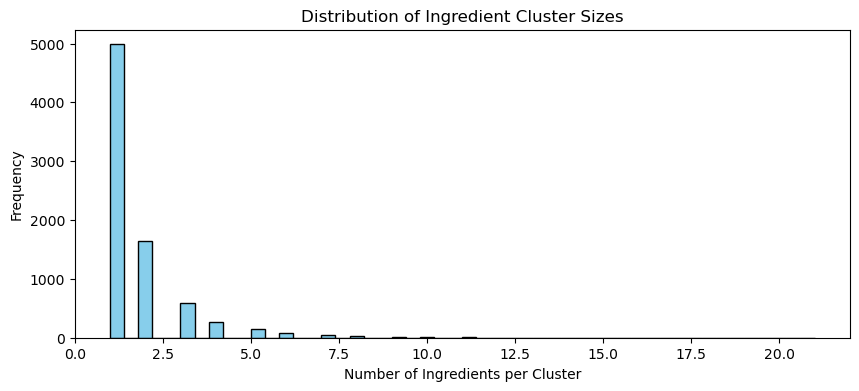

Total clusters: 7833
Average size: 1.70


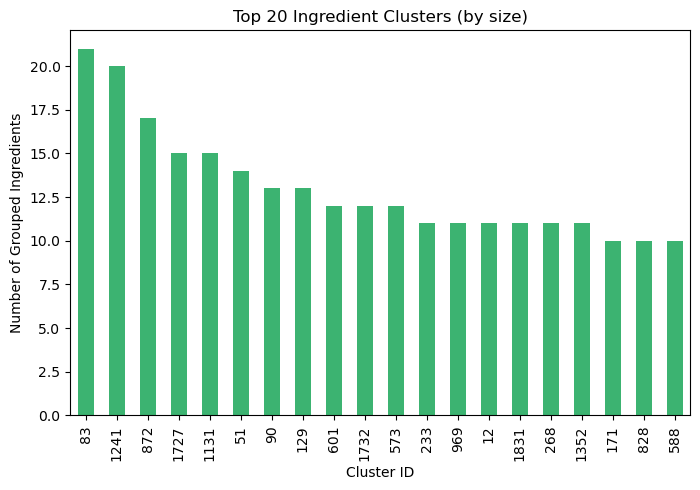

In [70]:
cluster_sizes = mapping_df["cluster"].value_counts()

plt.figure(figsize=(10,4))
plt.hist(cluster_sizes, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of Ingredient Cluster Sizes")
plt.xlabel("Number of Ingredients per Cluster")
plt.ylabel("Frequency")
plt.show()

print(f"Total clusters: {mapping_df['cluster'].nunique()}")
print(f"Average size: {cluster_sizes.mean():.2f}")

# Top 20 largest clusters
top_clusters = cluster_sizes.head(20)

plt.figure(figsize=(8,5))
top_clusters.plot(kind="bar", color="mediumseagreen")
plt.title("Top 20 Ingredient Clusters (by size)")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Grouped Ingredients")
plt.show()

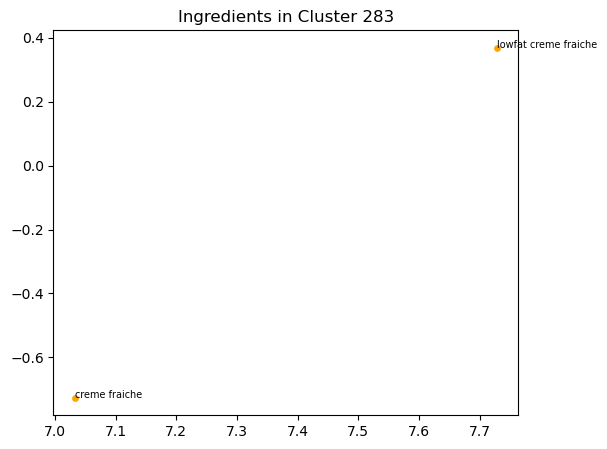

In [71]:
# Example of a specific cluster
cid = 283
subset = mapping_df[mapping_df["cluster"] == cid]

plt.figure(figsize=(6,5))
plt.scatter(subset["x"], subset["y"], color="orange", s=15)
for _, row in subset.iterrows():
    plt.text(row["x"], row["y"], row["ingredient"], fontsize=7)
plt.title(f"Ingredients in Cluster {cid}")
plt.show()

### 🧾 STEP 8 - Creating and checking the final result

In [72]:
def unique_preserve_order(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            seen.add(x)
            out.append(x)
    return out

df["ingredients_clean"] = df["ingredients_y"].apply(
    lambda lst: unique_preserve_order([mapping.get(x, x) for x in lst])
)

In [73]:
i = np.random.randint(len(df))
print("Before:", df.loc[i, "ingredients_y"])
print("After:", df.loc[i, "ingredients_clean"])

Before: ['sugar', 'flour', 'baking powder', 'unsweetened chocolate square', 'butter', 'milk', 'vanilla', 'brown sugar', 'white sugar', 'cocoa', 'coffee']
After: ['sugar', 'flour', 'baking powder', 'chocolate square', 'butter', 'milk', 'vanilla', 'brown sugar', 'white sugar', 'cocoa', 'coffee']


### 💾 STEP 9 - Saving the final cleaned DataFrame

In [74]:
df.head()

,name_x,nutrition,n_steps,ingredients_y,minutes,ingredients_reduced,ingredients_clean
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[winter squash, mexican seasoning, mixed spice...",55,"[spice, honey, butter, mexican seasoning, oliv...","[squash, mexican seasoning, spice, honey, butt..."
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[prepared pizza crust, sausage patty, egg, mil...",30,"[milk, sausage patty, egg, prepared pizza, sal...","[prepared pizza, sausage patty, egg, milk, sal..."
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[ground beef, yellow onion, diced tomato, toma...",130,"[chili powder, tomato soup, lettuce, diced tom...","[ground beef, sweet onion, diced tomato, tomat..."
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"[spreadable cheese with garlic and herb, new p...",45,"[shallot, red wine vinegar, bell pepper, tarra...","[herb cheese spread, potato, shallot, parsley,..."
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[tomato juice, apple cider vinegar, sugar, clo...",190,"[sugar, dry mustard, tomato juice, cinnamon, c...","[tomato juice, cider vinegar, sugar, clove oil..."


In [75]:
# Drop useless columns for the final csv
df.drop(columns=['ingredients_y', 'ingredients_reduced'], inplace=True)

# Rename ingredients_reduced to a simpler name
df.rename(columns={"ingredients_clean": "ingredients"}, inplace=True)

# Reorder columns to place "minutes" after "ingredients".
cols = df.columns.tolist()

if "ingredients" in cols and "minutes" in cols:
    cols.remove("minutes")
    idx = cols.index("ingredients")
    cols.insert(idx + 1, "minutes")
    df = df[cols]

df.head()

,name_x,nutrition,n_steps,ingredients,minutes
0,arriba baked winter squash mexican style,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"[squash, mexican seasoning, spice, honey, butt...",55
1,a bit different breakfast pizza,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"[prepared pizza, sausage patty, egg, milk, sal...",30
2,all in the kitchen chili,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"[ground beef, sweet onion, diced tomato, tomat...",130
3,alouette potatoes,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"[herb cheese spread, potato, shallot, parsley,...",45
4,amish tomato ketchup for canning,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"[tomato juice, cider vinegar, sugar, clove oil...",190


#### Export a dictionary of the ingredients

In [76]:
# Extract all unique final ingredients
ingredient_dict = sorted({ing for lst in df["ingredients"] for ing in lst})

dict_path = "data/clean_data/ingredient_dictionary.csv"
pd.DataFrame({"ingredient": ingredient_dict}).to_csv(dict_path, index=False)

print(f"✅ Dictionary exported with {len(ingredient_dict)} unique ingredients: {dict_path}")

✅ Dictionary exported with 7833 unique ingredients: data/clean_data/ingredient_dictionary.csv


#### Export the final cleaned DataFrame to a new CSV

In [77]:
output_path = "data/clean_data/ingredients_reduced.csv"
df.to_csv(output_path, index=False)
print(f"✅ New CSV saved: {output_path}")

✅ New CSV saved: data/clean_data/ingredients_reduced.csv
